In [1]:
import os
import torch
import pandas as pd
import random
import seaborn as sns
from PIL import Image


from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix


import torch.optim as optim 
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

E:\Anaconda\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
!pip install torch-lr-finder

In [3]:
!pip install split-folders

In [2]:
import splitfolders

In [3]:
data_dir = r'E:\Jupyter\Samples\CoffeeDisease_Samples'

In [4]:
class_labels = ['Cercospora', 'Healthy', 'Leaf Rust', 'Lichens', 'Sooty Mold']

In [5]:
def pad_image(image):
    # Get the dimensions of the image
    width, height = image.size

    # Find the longer side
    max_dim = max(width, height)

    # Create a square background image
    background = Image.new('RGB', (max_dim, max_dim), (255, 255, 255))

    # Calculate the position to paste the original image on the background
    pos = ((max_dim - width) // 2, (max_dim - height) // 2)

    # Paste the original image on the background
    background.paste(image, pos)

    return background

In [6]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [7]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        img = pad_image(img)
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [8]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)

In [9]:
splitfolders.ratio("E:\Jupyter\Samples\CoffeeDisease_Samples",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 1730 files [00:09, 174.73 files/s]


In [10]:
train = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/train",
                              transform=data_transforms)

val = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/val",
                              transform=data_transforms)

test = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/test",
                              transform=data_transforms)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="E:\Jupyter\Samples\CoffeeDisease_Samples",
                              transform=data_transforms)

In [11]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Cercospora': 0, 'Healthy': 1, 'Leaf Rust': 2, 'Lichens': 3, 'Sooty Mold': 4} 

Images per Class in TRAIN:
0    643
2    251
1    141
4    114
3     59
Name: count, dtype: int64 

Images per Class in VALIDATION:
0    183
2     72
1     40
4     32
3     17
Name: count, dtype: int64 

Images per Class in TEST:
0    93
2    37
1    21
4    18
3     9
Name: count, dtype: int64 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

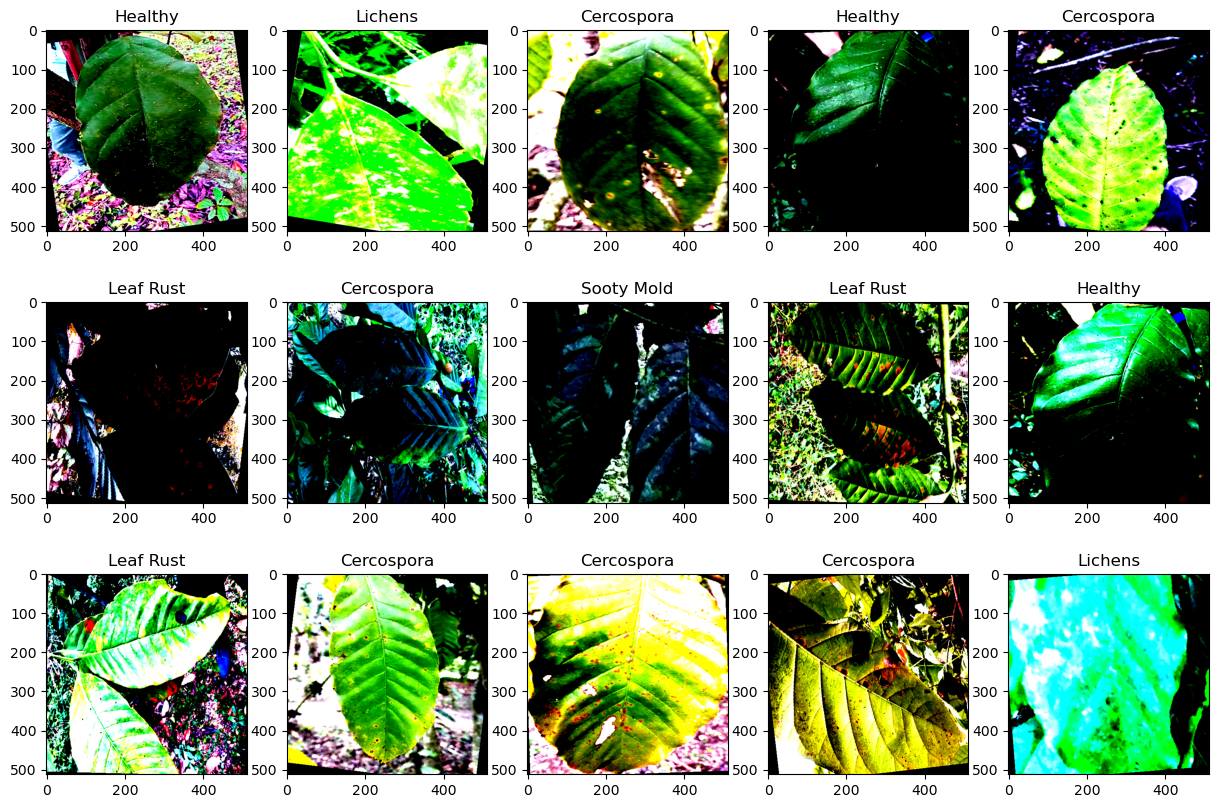

In [12]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data) - 1)
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

In [13]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [14]:
print("Length of training dataset:", len(train))
print("Length of validation dataset:", len(val))
print("Length of test dataset:", len(test))

Length of training dataset: 1208
Length of validation dataset: 344
Length of test dataset: 178


In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [17]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [18]:
# Create the CNN model
model = resnet

In [19]:
# Check for available GPUs
device = torch.device("cuda")

In [20]:
# Move the model to the GPU
model = model.to("cuda")

In [21]:
# Get the total number of samples and the number of samples per class
total_samples = 0
samples_per_class = []
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        num_samples = len(os.listdir(class_dir))
        total_samples += num_samples
        samples_per_class.append(num_samples)
        print(f"Number of images in {label}: {num_samples}")

# Calculate the class weights
class_weights = [total_samples / x for x in samples_per_class]
weights = torch.tensor(class_weights).to("cuda")

criterion = nn.BCEWithLogitsLoss(pos_weight=weights.cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)


Number of images in Cercospora: 919
Number of images in Healthy: 202
Number of images in Leaf Rust: 360
Number of images in Lichens: 85
Number of images in Sooty Mold: 164


In [22]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

E:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [24]:
def train_model(model, criterion, optimizer, num_epochs=32, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Early stopping details
    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  # Flag to indicate if early stopping occurred

    for epoch in range(num_epochs):
        if early_stop:  # Check if early stopping occurred
            print('Breaking out of epoch loop due to early stopping.')
            break  # Break out of the epoch loop

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().long()

                # Add an extra dimension to labels
                labels = torch.nn.functional.one_hot(labels, num_classes=5).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Check if early stopping conditions are met
            if phase == 'val':
                scheduler.step(epoch_loss)  
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  # Set the early stopping flag
                        break  # Break out of the phase loop

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, num_epochs=32, patience=6)

torch.save(model.state_dict(), 'model.pth')

print("Training finished...\n")


Epoch 1/32
----------
Learning Rate: 0.001
train Loss: 0.7266 Acc: 0.8394
val Loss: 0.7274 Acc: 0.8320
Epoch 2/32
----------
Learning Rate: 0.001
train Loss: 0.7210 Acc: 0.8417
val Loss: 0.7218 Acc: 0.8390
Epoch 3/32
----------
Learning Rate: 0.001
train Loss: 0.7146 Acc: 0.8291
val Loss: 0.6642 Acc: 0.8430
Epoch 4/32
----------
Learning Rate: 0.001
train Loss: 0.6588 Acc: 0.8472
val Loss: 0.6460 Acc: 0.8372
Epoch 5/32
----------
Learning Rate: 0.001
train Loss: 0.6641 Acc: 0.8434
val Loss: 0.6580 Acc: 0.8215
Early stopping counter: 1 out of 6
Epoch 6/32
----------
Learning Rate: 0.001
train Loss: 0.6284 Acc: 0.8522
val Loss: 0.6282 Acc: 0.8529
Epoch 7/32
----------
Learning Rate: 0.001
train Loss: 0.6299 Acc: 0.8500
val Loss: 0.6697 Acc: 0.8366
Early stopping counter: 1 out of 6
Epoch 8/32
----------
Learning Rate: 0.001
train Loss: 0.6436 Acc: 0.8437
val Loss: 0.6477 Acc: 0.8244
Early stopping counter: 2 out of 6
Epoch 9/32
----------
Learning Rate: 0.001
train Loss: 0.6257 Acc: 0.85

In [29]:
def test_model():
    model = models.resnet50(weights = None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5)

    model = model.to(device)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    print("Test Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_labels))

    # Return a flattened array of all predictions
    return np.array(all_predictions).flatten()

# Call the function to test the model
all_preds = test_model()


Test Classification Report:
              precision    recall  f1-score   support

  Cercospora       0.84      0.71      0.77        93
     Healthy       0.95      0.86      0.90        21
   Leaf Rust       0.49      0.68      0.57        37
     Lichens       0.36      0.44      0.40         9
  Sooty Mold       0.67      0.67      0.67        18

    accuracy                           0.70       178
   macro avg       0.66      0.67      0.66       178
weighted avg       0.74      0.70      0.71       178



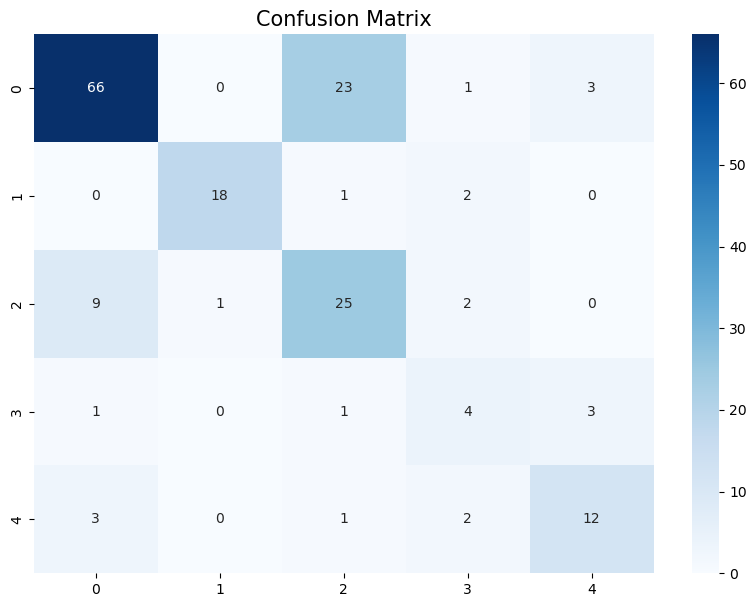

In [56]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

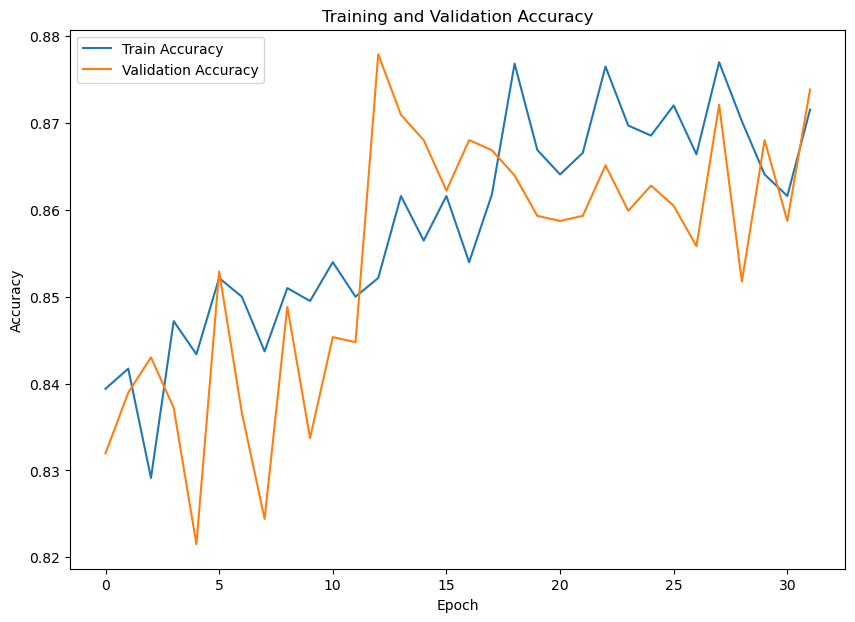

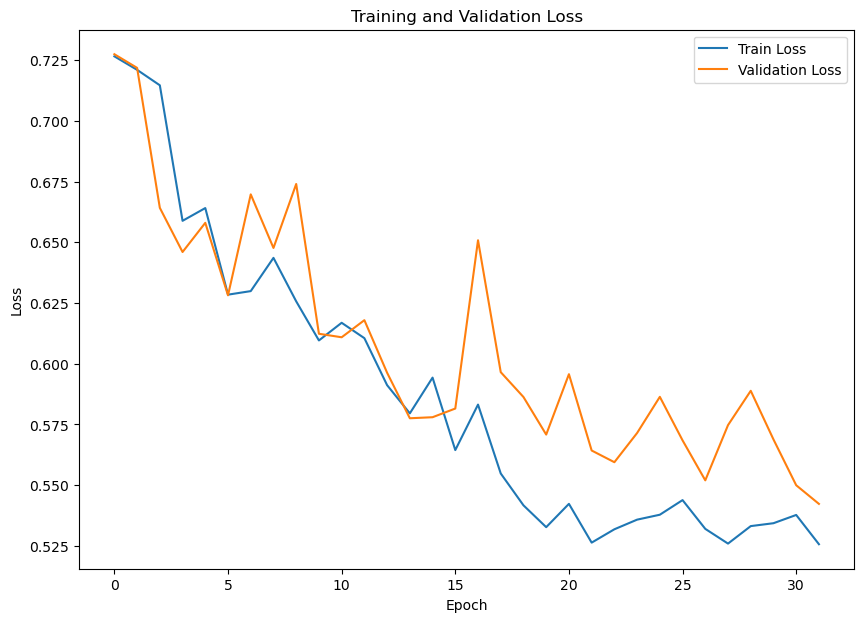

Best val Loss: 0.5423
Best val Acc: 0.8779


In [57]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


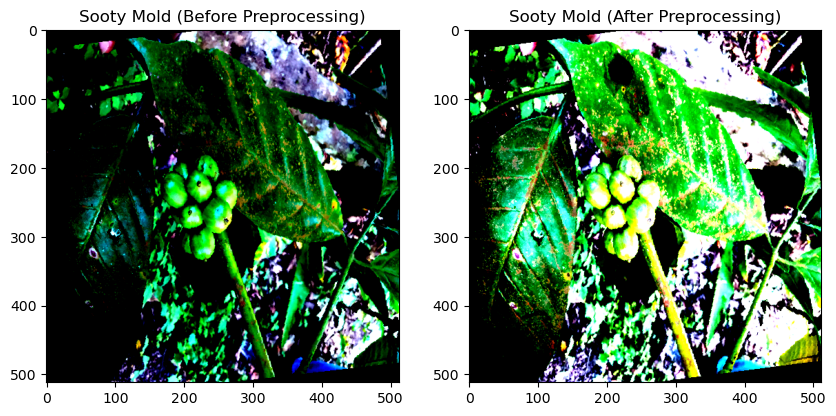

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [53]:
# Initialize the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(class_labels) 
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved parameters
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
# Don't forget to set the model to evaluation mode if you're doing inference
model.eval()

# Define the prediction function
def predict_image(image_path, model, threshold=0.55):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        # Get the probabilities from the outputs
        probs = torch.sigmoid(output)
        # Apply a threshold
        preds = probs > threshold
        # Get the indices of the positive predictions
        positive_indices = [i for i, x in enumerate(preds[0]) if x]
        # Return the corresponding class labels
        return [class_labels[i] for i in positive_indices]

# Use the prediction function
image_path = "E:\Jupyter\ML\ValidationSamples\CLR (1).jpg"  
print("Predicted Class: ", predict_image(image_path, model))

Predicted Class:  ['Cercospora']
